In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the same architecture using PyTorch
class MNISTNet(nn.Module):
  def __init__(self):
    super(MNISTNet, self).__init__()

    #Layer 1: 784 → 128
    self.fc1 = nn.Linear(784, 128)

    # Layer 2: 128 → 10
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):

    # Flatten input
    x = x.view(-1, 28 * 28)

    # 2. Layer 1 + ReLU
    x = F.relu(self.fc1(x))

    # 3. Layer 2
    #x = F.softmax(self.fc2(x), dim=1)
    x = self.fc2(x)

    return x


# Create a Model instance
model = MNISTNet()

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")



MNISTNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 101770


In [6]:
# Load data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #, momentum=0.5)

print(f"\nLoss function: {criterion}")
print(f"Optimizer: {optimizer}")


Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [7]:
# Training Loop

def train_epoch(model, train_loader, criterion, optimizer):
  #train for one epoch

  model.train() # training mode
  total_loss = 0.0

  for images, labels in train_loader:
    # 1. Zero gradient
    optimizer.zero_grad()

    # 2. Forward pass
    outputs = model(images)

    # 3. Calculate loss
    loss = criterion(outputs, labels)

    # 4. Backward pass
    loss.backward()

    # 5. Update Weights
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(train_loader)

def evaluate(model, test_loader):
  model.eval() # evaluation mode
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in test_loader:
      outputs = model(images)
      predictions = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predictions == labels).sum().item()

  return 100 * correct / total

In [8]:
# Training
num_epochs = 10

print("Starting PyTorch training...")
print(f"Initial test accuracy: {evaluate(model, test_loader):.2f}%\n")

epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
  # Train
  train_loss = train_epoch(model, train_loader, criterion, optimizer)

  # Evaluate
  test_accuracy = evaluate(model, test_loader)

  # Save for plotting
  epoch_losses.append(train_loss)
  epoch_accuracies.append(test_accuracy)


  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

print("\nTraining complete!")


Starting PyTorch training...
Initial test accuracy: 6.13%

Epoch 1/10, Train Loss: 0.5800, Test Accuracy: 91.10%
Epoch 2/10, Train Loss: 0.3042, Test Accuracy: 92.45%
Epoch 3/10, Train Loss: 0.2582, Test Accuracy: 93.29%
Epoch 4/10, Train Loss: 0.2257, Test Accuracy: 93.92%
Epoch 5/10, Train Loss: 0.2002, Test Accuracy: 94.55%
Epoch 6/10, Train Loss: 0.1799, Test Accuracy: 95.02%
Epoch 7/10, Train Loss: 0.1634, Test Accuracy: 95.51%
Epoch 8/10, Train Loss: 0.1493, Test Accuracy: 95.69%
Epoch 9/10, Train Loss: 0.1378, Test Accuracy: 96.13%
Epoch 10/10, Train Loss: 0.1276, Test Accuracy: 96.33%

Training complete!


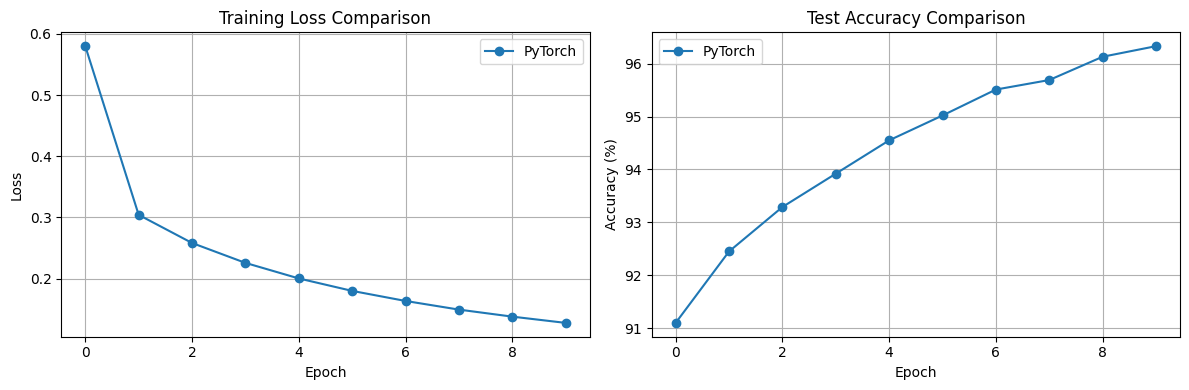


Final Results:
PyTorch - Loss: 0.1276, Accuracy: 96.33%
From Scratch - Loss: 0.0185, Accuracy: 97.91%


In [9]:
# Plot comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss comparison
axes[0].plot(epoch_losses, label='PyTorch', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True)

# Accuracy comparison
axes[1].plot(epoch_accuracies, label='PyTorch', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Test Accuracy Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('pytorch_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal Results:")
print(f"PyTorch - Loss: {epoch_losses[-1]:.4f}, Accuracy: {epoch_accuracies[-1]:.2f}%")
print(f"From Scratch - Loss: 0.0185, Accuracy: 97.91%")

In [10]:
# 1. Inspect gradients
print("=" * 50)
print("GRADIENT INSPECTION")
print("=" * 50)

# Get one batch
images, labels = next(iter(train_loader))

# Forward pass
optimizer.zero_grad()
outputs = model(images)
loss = criterion(outputs, labels)

# Before backward
print(f"\nBefore .backward():")
print(f"fc1.weight.grad: {model.fc1.weight.grad}")
print(f"fc2.weight.grad: {model.fc2.weight.grad}")

# Backward pass
loss.backward()

# After backward
print(f"\nAfter .backward():")
print(f"fc1.weight.grad shape: {model.fc1.weight.grad.shape}")
print(f"fc1.weight.grad sample: {model.fc1.weight.grad[0, :5]}")
print(f"fc2.weight.grad shape: {model.fc2.weight.grad.shape}")

print("\n✅ PyTorch computed ALL gradients automatically!")

GRADIENT INSPECTION

Before .backward():
fc1.weight.grad: None
fc2.weight.grad: None

After .backward():
fc1.weight.grad shape: torch.Size([128, 784])
fc1.weight.grad sample: tensor([0.0007, 0.0007, 0.0007, 0.0007, 0.0007])
fc2.weight.grad shape: torch.Size([10, 128])

✅ PyTorch computed ALL gradients automatically!


In [11]:
# 2. Compare parameter counts
print("=" * 50)
print("PARAMETER COMPARISON")
print("=" * 50)

print("\nYour from-scratch network:")
print(f"W1: {784 * 128:,} parameters")
print(f"b1: {128:,} parameters")
print(f"W2: {128 * 10:,} parameters")
print(f"b2: {10:,} parameters")
print(f"Total: {784*128 + 128 + 128*10 + 10:,} parameters")

print("\nPyTorch network:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,} parameters")
print(f"Total: {sum(p.numel() for p in model.parameters()):,} parameters")

print("\n✅ Same architecture, same parameter count!")

PARAMETER COMPARISON

Your from-scratch network:
W1: 100,352 parameters
b1: 128 parameters
W2: 1,280 parameters
b2: 10 parameters
Total: 101,770 parameters

PyTorch network:
fc1.weight: 100,352 parameters
fc1.bias: 128 parameters
fc2.weight: 1,280 parameters
fc2.bias: 10 parameters
Total: 101,770 parameters

✅ Same architecture, same parameter count!


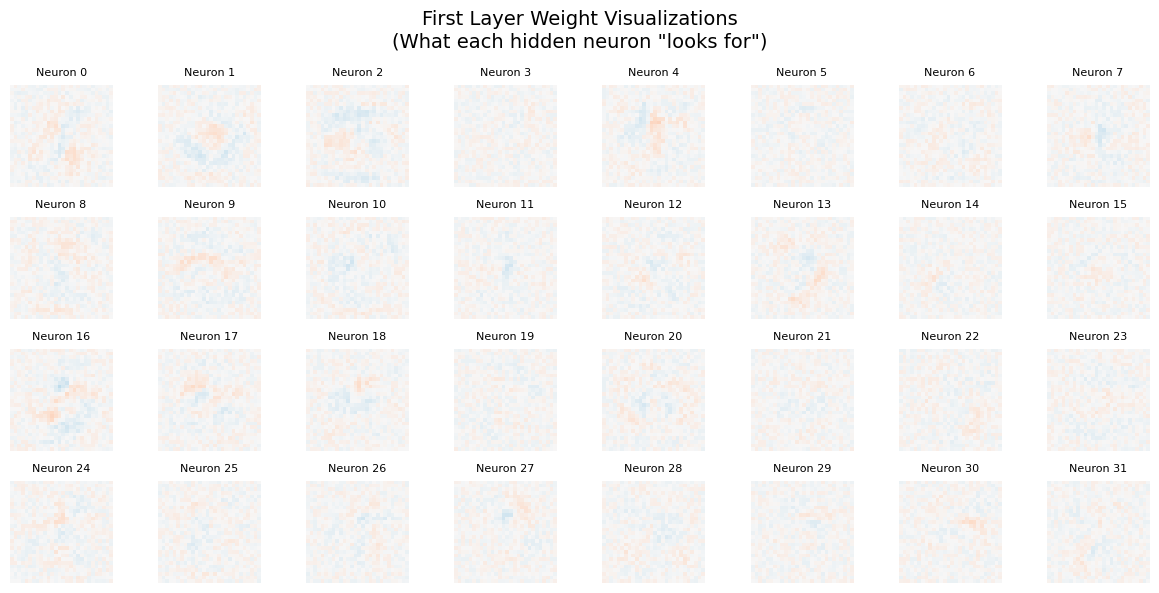

Each neuron learned to detect different patterns!


In [12]:
# 3. Visualize learned weights
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.ravel()

# Get first layer weights
fc1_weights = model.fc1.weight.detach().cpu().numpy()

for i in range(32):
    # Reshape weights to 28×28 (input image shape)
    weight_image = fc1_weights[i].reshape(28, 28)

    axes[i].imshow(weight_image, cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[i].axis('off')
    axes[i].set_title(f'Neuron {i}', fontsize=8)

plt.suptitle('First Layer Weight Visualizations\n(What each hidden neuron "looks for")', fontsize=14)
plt.tight_layout()
plt.savefig('weight_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

print("Each neuron learned to detect different patterns!")

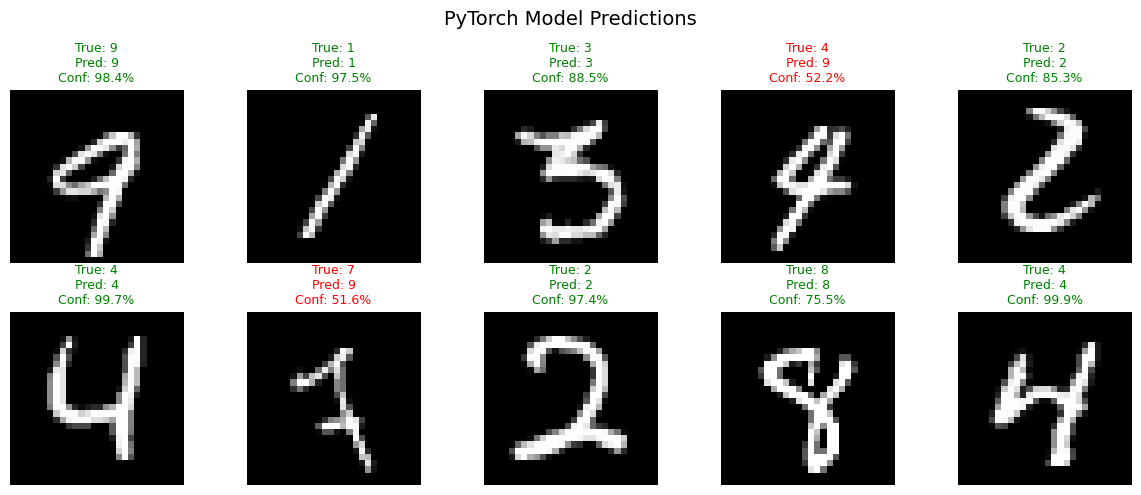

In [13]:
# Test on individual examples with visualization
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

model.eval()
with torch.no_grad():
    for i in range(10):
        idx = torch.randint(0, len(test_dataset), (1,)).item()
        image, true_label = test_dataset[idx]

        output = model(image.unsqueeze(0))
        prediction = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1).max().item()

        axes[i].imshow(image.squeeze(), cmap='gray')
        color = 'green' if prediction == true_label else 'red'
        axes[i].set_title(
            f'True: {true_label}\nPred: {prediction}\nConf: {confidence:.1%}',
            color=color, fontsize=9
        )
        axes[i].axis('off')

plt.suptitle('PyTorch Model Predictions', fontsize=14)
plt.tight_layout()
plt.show()

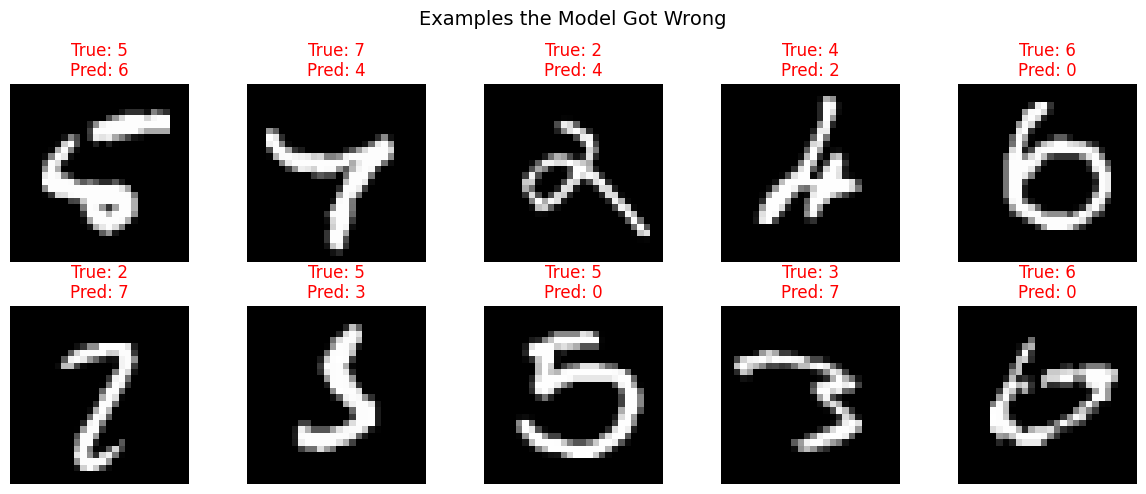

Total errors found in sample: 10


In [15]:
# Error analysis (what does the model get wrong?)
model.eval()
errors = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predictions = outputs.argmax(dim=1)

        # Find wrong predictions
        wrong_mask = predictions != labels
        if wrong_mask.any():
            wrong_images = images[wrong_mask]
            wrong_preds = predictions[wrong_mask]
            wrong_labels = labels[wrong_mask]

            for img, pred, label in zip(wrong_images, wrong_preds, wrong_labels):
                errors.append((img, pred.item(), label.item()))

            if len(errors) >= 10:
                break

# Show first 10 errors
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i, (img, pred, true) in enumerate(errors[:10]):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'True: {true}\nPred: {pred}', color='red')
    axes[i].axis('off')

plt.suptitle('Examples the Model Got Wrong', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Total errors found in sample: {len(errors)}")

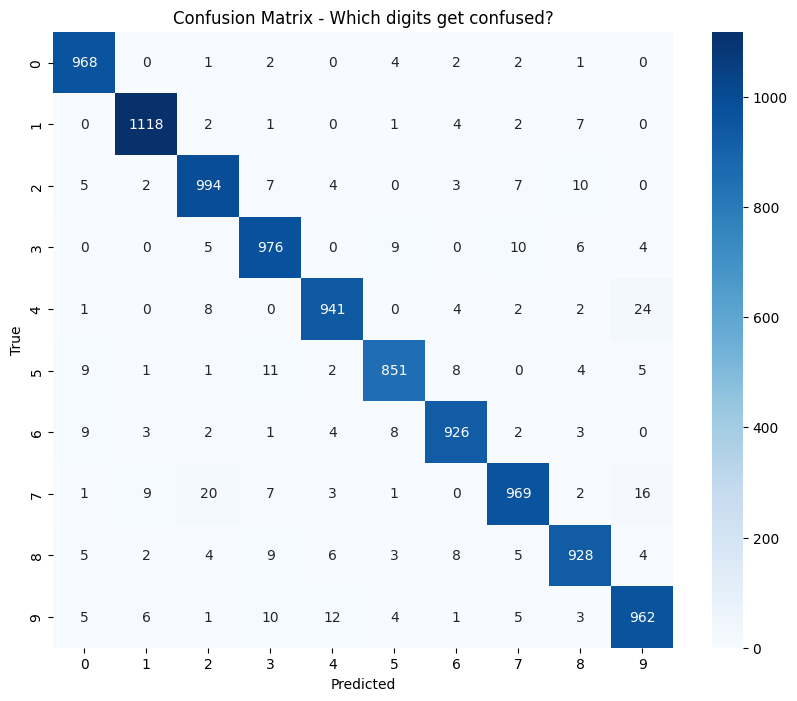


Most confused digit pairs:
  True '4' predicted as '9': 24 times
  True '7' predicted as '2': 20 times
  True '7' predicted as '9': 16 times
  True '9' predicted as '4': 12 times
  True '5' predicted as '3': 11 times


In [16]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predictions = outputs.argmax(dim=1)
        all_preds.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Which digits get confused?')
plt.show()

# Find most confused pairs
print("\nMost confused digit pairs:")
cm_copy = cm.copy()
for i in range(10):
    cm_copy[i][i] = 0  # Zero out correct predictions

for _ in range(5):
    idx = cm_copy.argmax()
    true_digit = idx // 10
    pred_digit = idx % 10
    count = cm_copy[true_digit][pred_digit]
    print(f"  True '{true_digit}' predicted as '{pred_digit}': {count} times")
    cm_copy[true_digit][pred_digit] = 0